C:\python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=KeypointRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


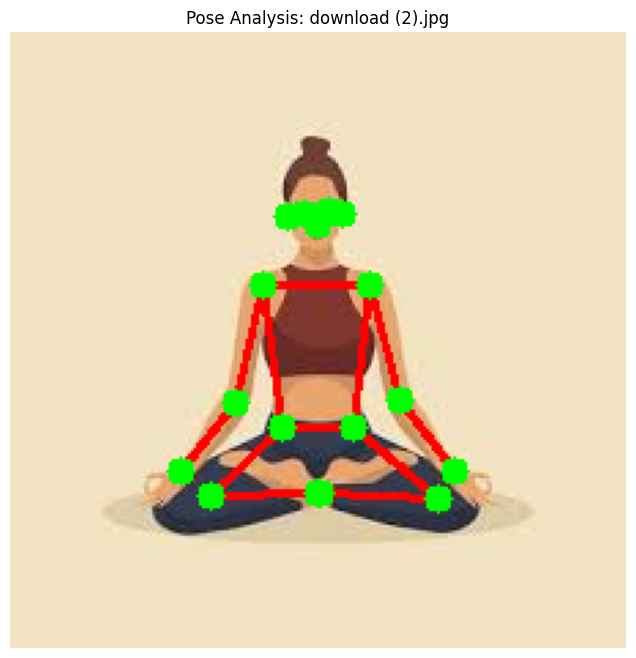

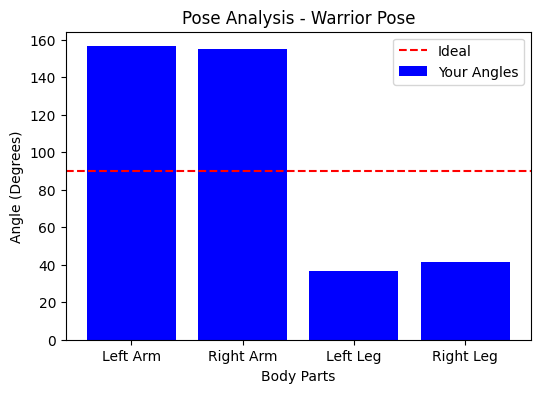


🔹 **Pose Accuracy: 74.03%** 🔹
--------------------------------------------------


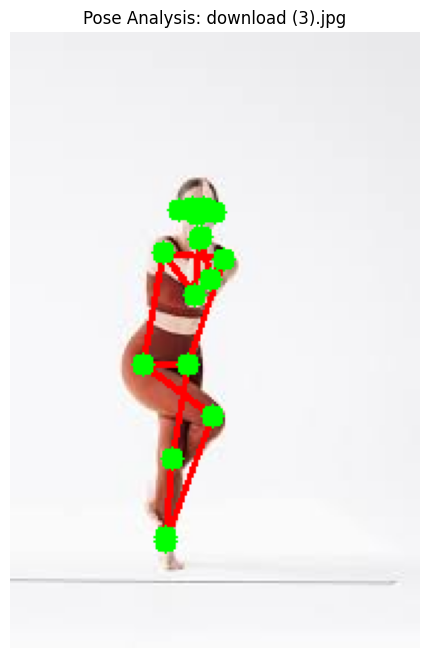

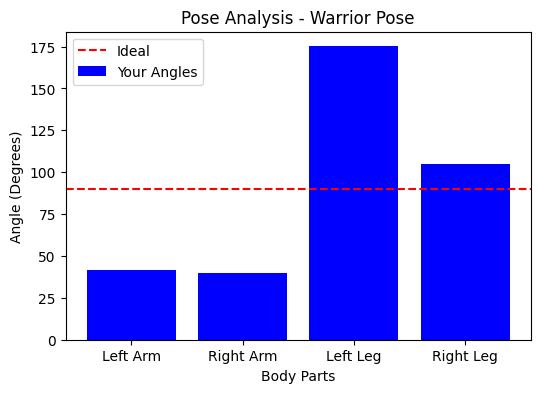


🔹 **Pose Accuracy: 92.77%** 🔹
--------------------------------------------------


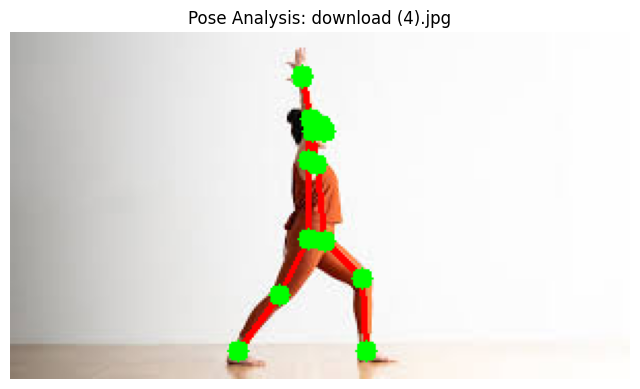

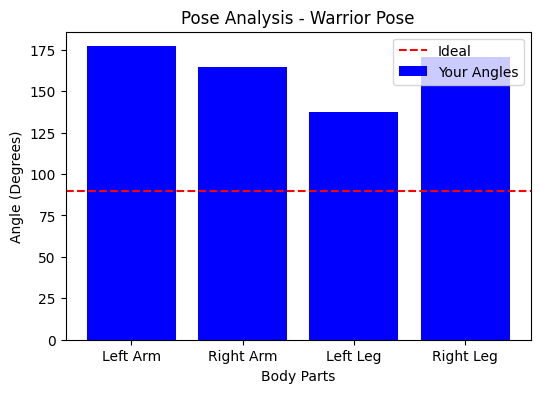


🔹 **Pose Accuracy: 96.62%** 🔹
--------------------------------------------------


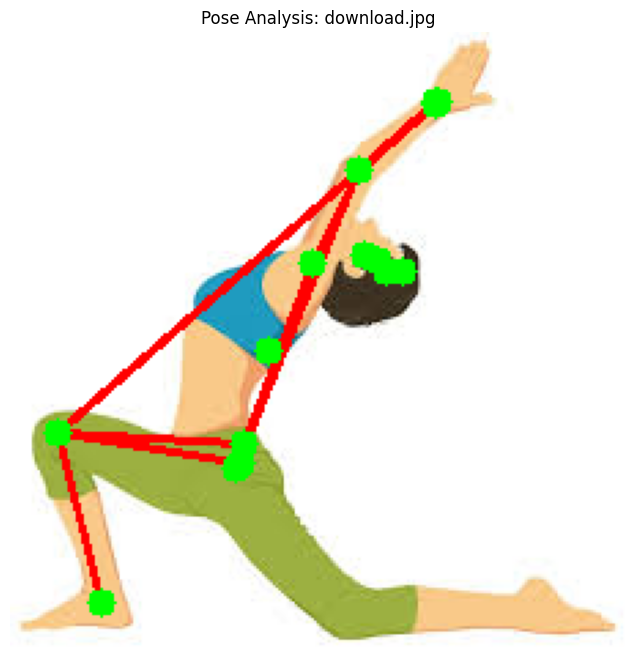

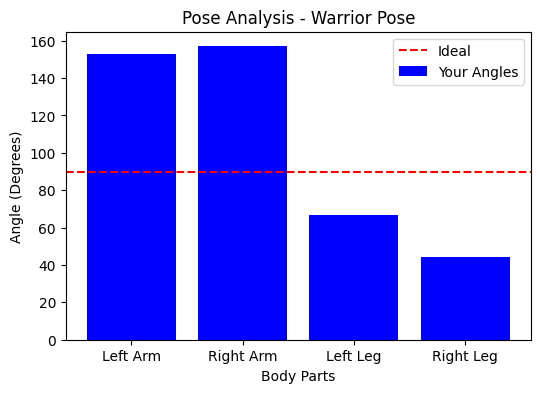


🔹 **Pose Accuracy: 80.15%** 🔹
--------------------------------------------------


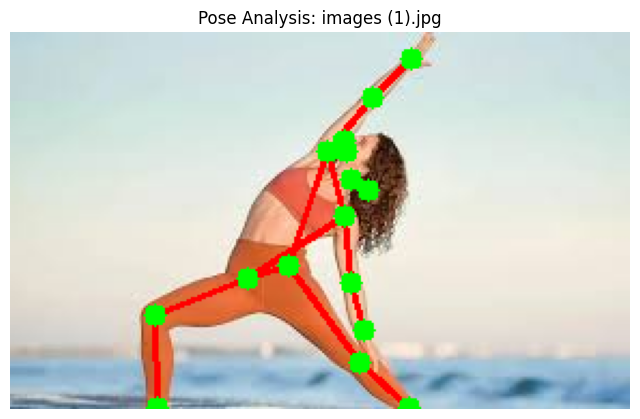

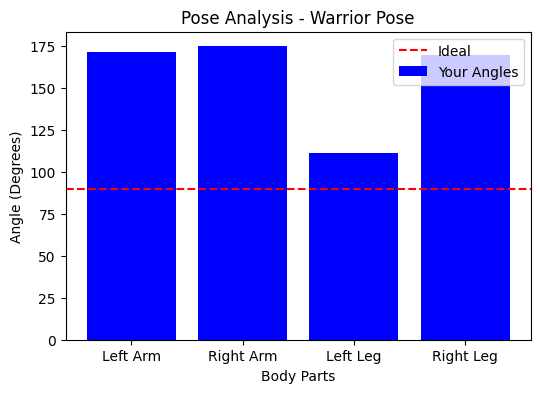


🔹 **Pose Accuracy: 94.67%** 🔹
--------------------------------------------------


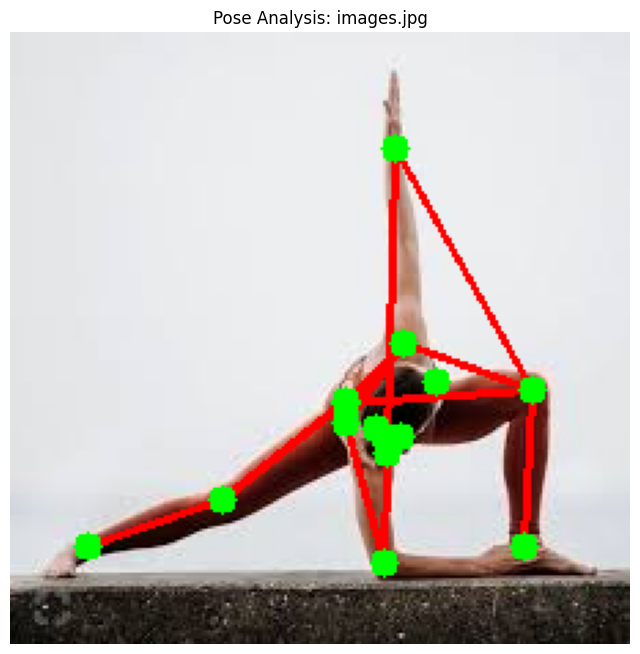

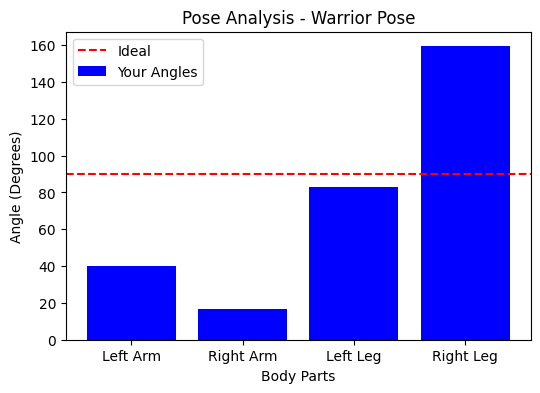


🔹 **Pose Accuracy: 89.16%** 🔹
--------------------------------------------------


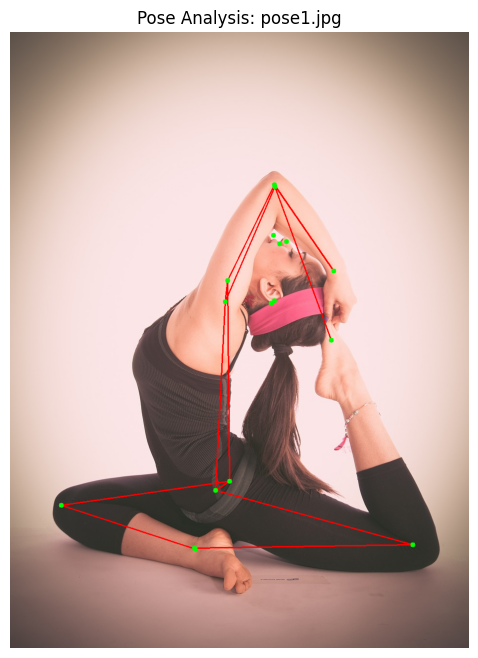

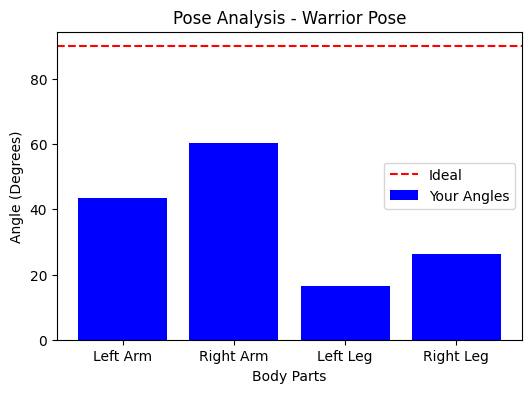


🔹 **Pose Accuracy: 81.71%** 🔹
--------------------------------------------------


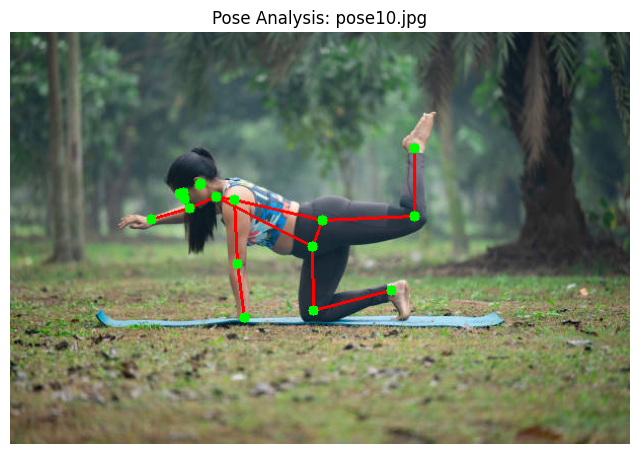

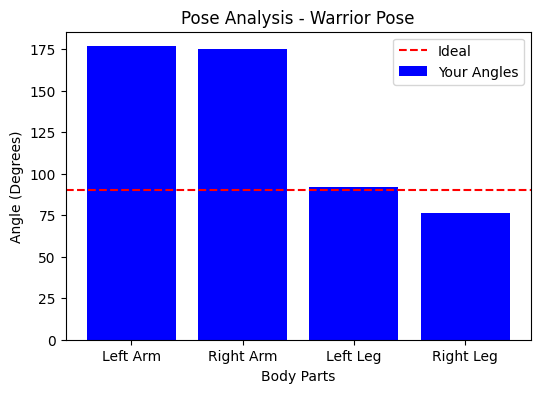


🔹 **Pose Accuracy: 85.92%** 🔹
--------------------------------------------------


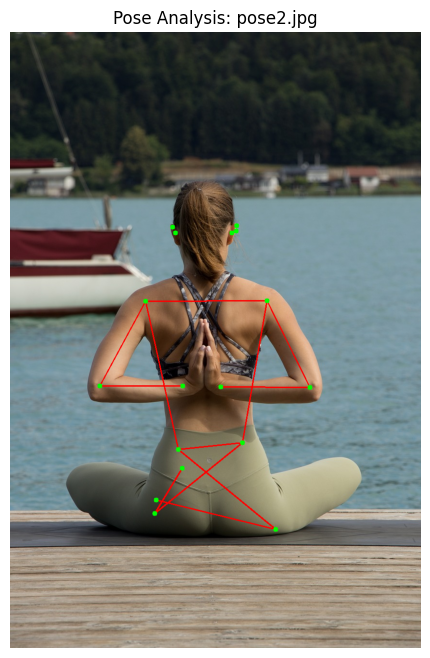

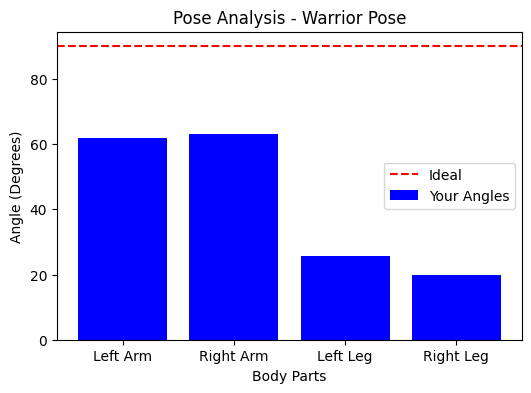


🔹 **Pose Accuracy: 80.56%** 🔹
--------------------------------------------------


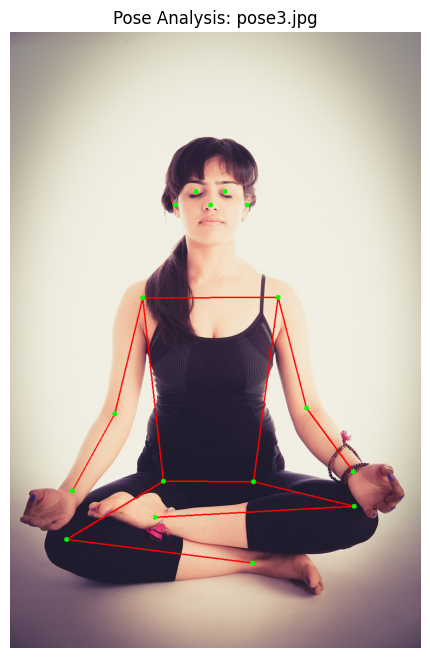

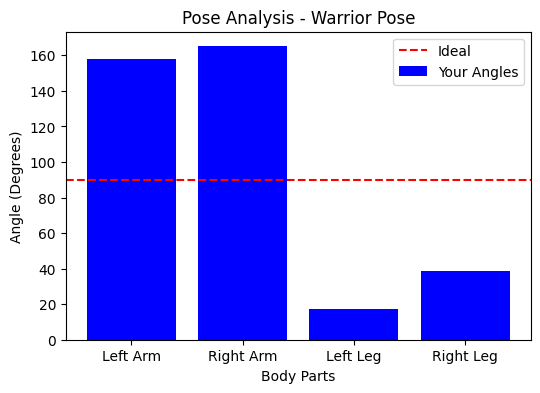


🔹 **Pose Accuracy: 68.59%** 🔹
--------------------------------------------------


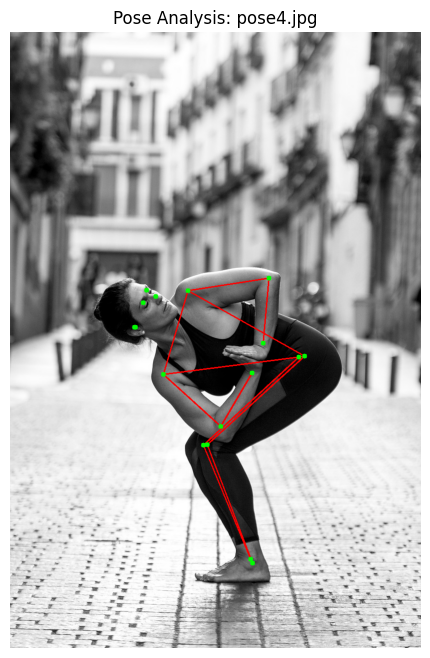

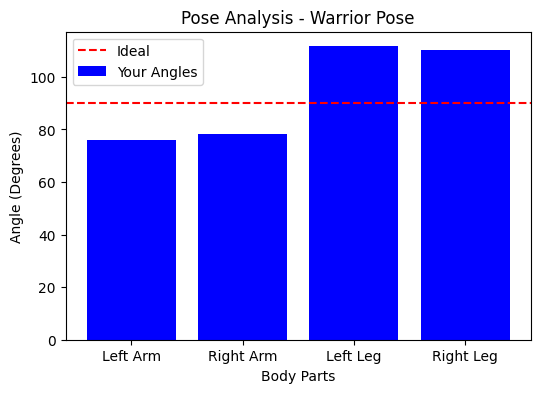


🔹 **Pose Accuracy: 99.98%** 🔹
--------------------------------------------------


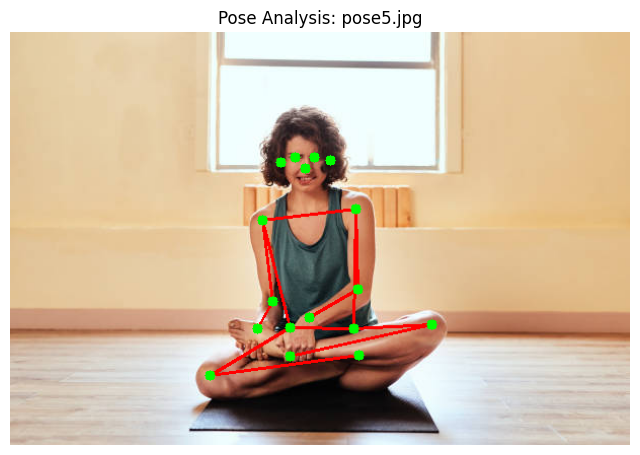

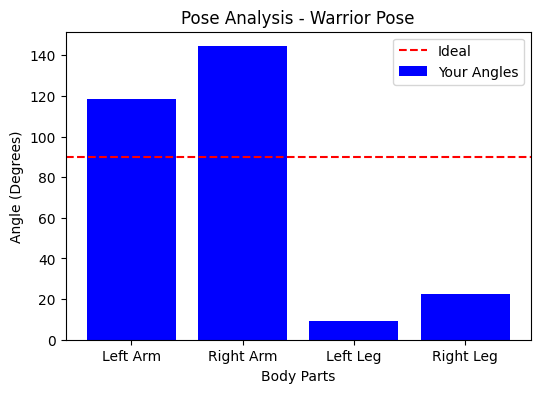


🔹 **Pose Accuracy: 64.70%** 🔹
--------------------------------------------------


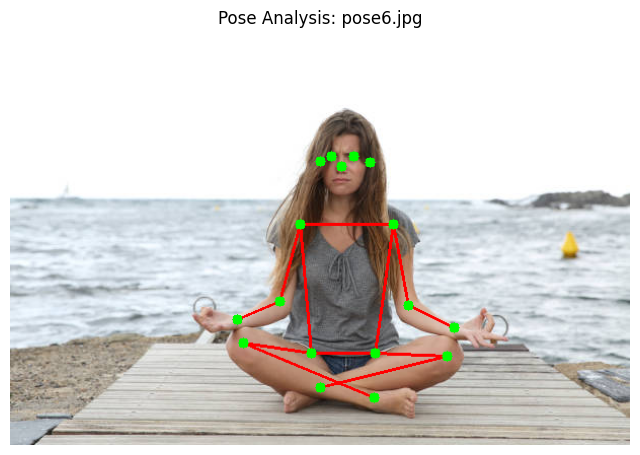

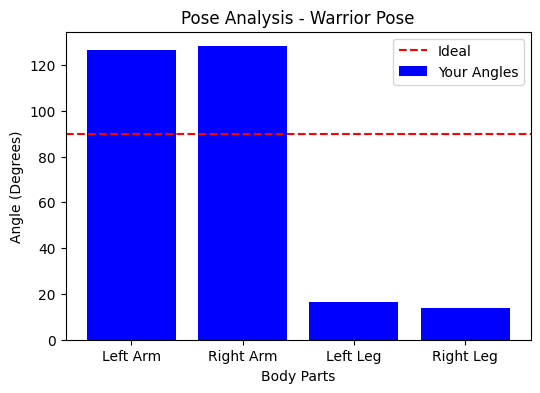


🔹 **Pose Accuracy: 64.90%** 🔹
--------------------------------------------------


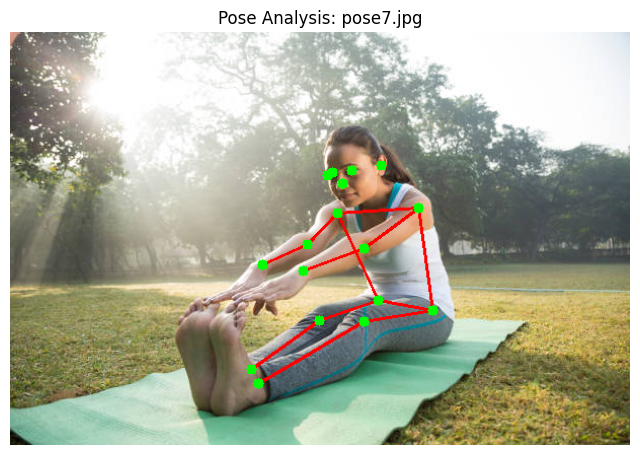

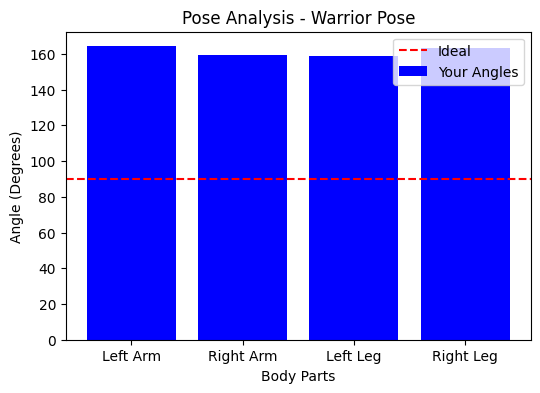


🔹 **Pose Accuracy: 98.02%** 🔹
--------------------------------------------------


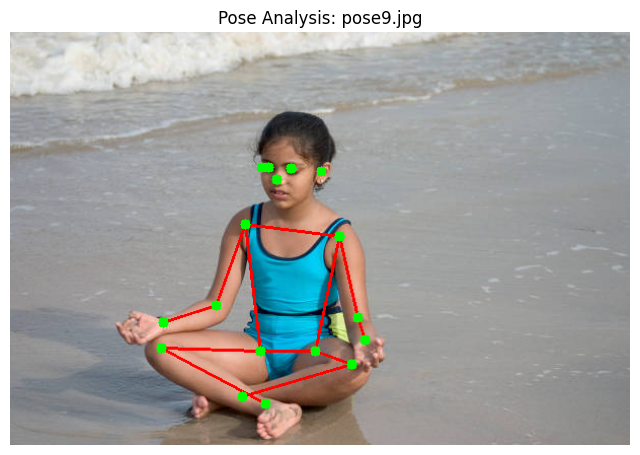

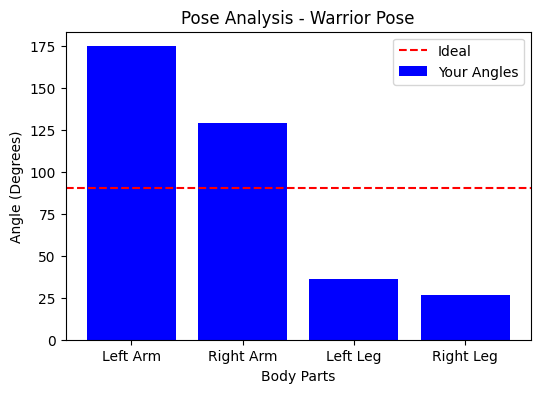


🔹 **Pose Accuracy: 70.39%** 🔹
--------------------------------------------------


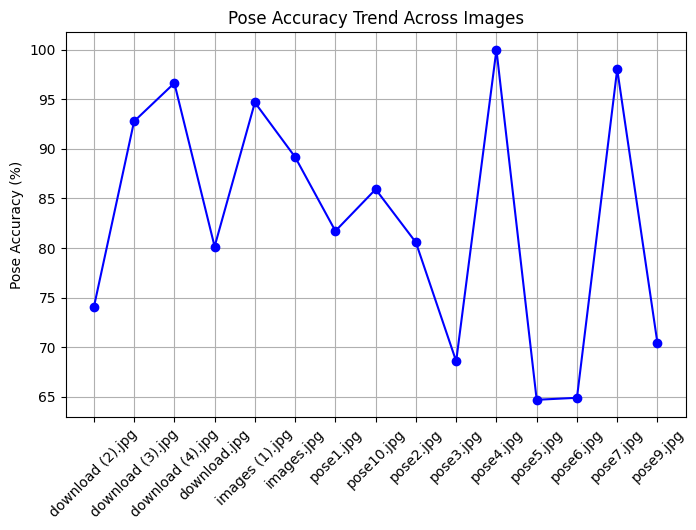

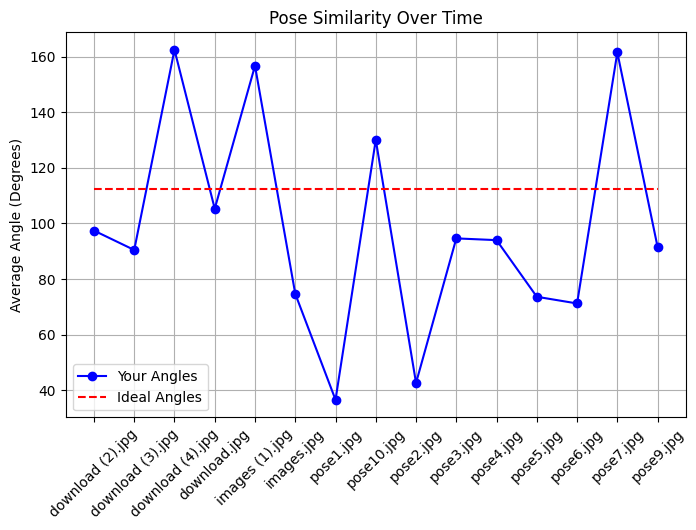

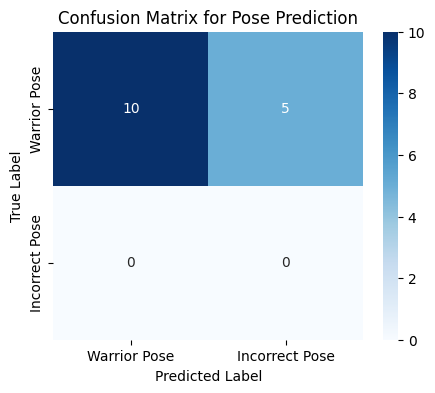

In [1]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from torchvision import transforms
from torchvision.models.detection import keypointrcnn_resnet50_fpn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix

# Load pre-trained Keypoint R-CNN
model = keypointrcnn_resnet50_fpn(pretrained=True)
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define Keypoint Connections
COCO_PERSON_SKELETON = [
    (5, 7), (7, 9), (6, 8), (8, 10), (5, 6), 
    (11, 13), (13, 15), (12, 14), (14, 16), (11, 12), 
    (5, 11), (6, 12)
]

# Ideal Angles for Yoga Poses
IDEAL_ANGLES = {
    "Warrior Pose": {"Left Arm": 90, "Right Arm": 90, "Left Leg": 135, "Right Leg": 135},
    "Tree Pose": {"Left Arm": 90, "Right Arm": 90, "Left Leg": 45, "Right Leg": 150},
}

# Function to Calculate Angles
def calculate_angle(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba, bc = a - b, c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    return np.degrees(np.arccos(np.clip(cosine_angle, -1.0, 1.0)))

# Analyze Pose
def analyze_pose(keypoints, pose_name):
    feedback_list, angle_data = [], {}
    joints = {
        "Left Arm": (keypoints[5], keypoints[7], keypoints[9]),
        "Right Arm": (keypoints[6], keypoints[8], keypoints[10]),
        "Left Leg": (keypoints[11], keypoints[13], keypoints[15]),
        "Right Leg": (keypoints[12], keypoints[14], keypoints[16])
    }

    ideal_angles = IDEAL_ANGLES.get(pose_name, {})
    actual_angles = []

    for limb, (a, b, c) in joints.items():
        angle = calculate_angle(a[:2], b[:2], c[:2])
        angle_data[limb] = angle
        
        if limb in ideal_angles:
            actual_angles.append(angle)
            if not (ideal_angles[limb] - 10 <= angle <= ideal_angles[limb] + 10):
                feedback_list.append(f"⚠ Adjust {limb} (Ideal: {ideal_angles[limb]}°, Your: {angle:.1f}°)")

    similarity = 0
    if actual_angles and ideal_angles:
        similarity = cosine_similarity([actual_angles], [list(ideal_angles.values())])[0][0] * 100

    return feedback_list, angle_data, similarity

# Load Image
def load_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    transform = transforms.Compose([transforms.ToTensor()])
    return img, transform(img).to(device)

# Image Folder
image_folder = r"C:\Users\ASUS\Desktop\projeccct\HumanPoseEstimation\images"
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Store Data for Graphs
pose_accuracies, image_names, all_actual_angles, all_ideal_angles = [], [], [], []

# Process Each Image
for image_path in image_files:
    img, img_tensor = load_image(image_path)

    # Pose Estimation
    with torch.no_grad():
        output = model([img_tensor])

    keypoints = output[0]['keypoints'][0].cpu().numpy()
    pose_name = "Warrior Pose"

    feedback, angles, accuracy = analyze_pose(keypoints, pose_name)

    pose_accuracies.append(accuracy)
    image_names.append(os.path.basename(image_path))
    all_actual_angles.append(list(angles.values()))
    all_ideal_angles.append(list(IDEAL_ANGLES[pose_name].values()))

    # Draw Keypoints & Skeleton
    for partA, partB in COCO_PERSON_SKELETON:
        cv2.line(img, tuple(map(int, keypoints[partA][:2])), tuple(map(int, keypoints[partB][:2])), (255, 0, 0), 2)

    for x, y, conf in keypoints:
        if conf > 0.5:
            cv2.circle(img, (int(x), int(y)), 5, (0, 255, 0), -1)

    # Show Image
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Pose Analysis: {os.path.basename(image_path)}")
    plt.show()

    # Angle Bar Chart
    plt.figure(figsize=(6, 4))
    plt.bar(angles.keys(), angles.values(), color='blue', label='Your Angles')
    plt.axhline(y=IDEAL_ANGLES[pose_name]["Left Arm"], color='r', linestyle='--', label="Ideal")
    plt.xlabel("Body Parts")
    plt.ylabel("Angle (Degrees)")
    plt.legend()
    plt.title(f"Pose Analysis - {pose_name}")
    plt.show()

    print(f"\n🔹 **Pose Accuracy: {accuracy:.2f}%** 🔹")
    print("-" * 50)

# 📊 Accuracy Trend Across Images
plt.figure(figsize=(8, 5))
plt.plot(image_names, pose_accuracies, marker='o', linestyle='-', color='blue')
plt.xticks(rotation=45)
plt.ylabel("Pose Accuracy (%)")
plt.title("Pose Accuracy Trend Across Images")
plt.grid()
plt.show()

# 📈 Pose Similarity Trend
plt.figure(figsize=(8, 5))
plt.plot(image_names, [np.mean(a) for a in all_actual_angles], label="Your Angles", color='blue', marker='o')
plt.plot(image_names, [np.mean(a) for a in all_ideal_angles], label="Ideal Angles", color='red', linestyle='--')
plt.xticks(rotation=45)
plt.ylabel("Average Angle (Degrees)")
plt.legend()
plt.title("Pose Similarity Over Time")
plt.grid()
plt.show()

# 📊 Confusion Matrix (If Labels Are Available)
true_labels = ["Warrior Pose"] * len(image_files)  # Replace with actual labels if available
predicted_labels = ["Warrior Pose" if acc > 80 else "Incorrect Pose" for acc in pose_accuracies]

cm = confusion_matrix(true_labels, predicted_labels, labels=["Warrior Pose", "Incorrect Pose"])
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=["Warrior Pose", "Incorrect Pose"], yticklabels=["Warrior Pose", "Incorrect Pose"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Pose Prediction")
plt.show()


In [3]:
import pandas as pd
from fpdf import FPDF

# 📁 **Save Pose Analysis Data as CSV**
csv_data = []
for i, img_name in enumerate(image_names):
    row = {"Image Name": img_name, "Pose Accuracy (%)": pose_accuracies[i]}
    row.update({f"{k} Angle": v for k, v in zip(IDEAL_ANGLES["Warrior Pose"].keys(), all_actual_angles[i])})
    csv_data.append(row)

df = pd.DataFrame(csv_data)
csv_path = "pose_analysis_results.csv"
df.to_csv(csv_path, index=False)
print(f"✅ Pose analysis results saved as {csv_path}")

# 📄 **Generate PDF Report**
class PDFReport(FPDF):
    def header(self):
        self.set_font("Arial", "B", 16)
        self.cell(200, 10, "Pose Estimation Analysis Report", ln=True, align="C")

pdf = PDFReport()
pdf.set_auto_page_break(auto=True, margin=15)
pdf.add_page()

pdf.set_font("Arial", size=12)
pdf.cell(200, 10, f"Total Images Analyzed: {len(image_names)}", ln=True)

# 🔹 **Add Each Image's Analysis**
for i, img_name in enumerate(image_names):
    pdf.set_font("Arial", "B", 12)
    pdf.cell(0, 10, f"\nPose Analysis: {img_name}", ln=True)

    pdf.set_font("Arial", size=10)
    pdf.cell(0, 10, f"Pose Accuracy: {pose_accuracies[i]:.2f}%", ln=True)

    for k, v in zip(IDEAL_ANGLES["Warrior Pose"].keys(), all_actual_angles[i]):
        pdf.cell(0, 10, f"{k}: {v:.2f}°", ln=True)

# 🔹 **Save and Export PDF**
pdf_path = "pose_analysis_report.pdf"
pdf.output(pdf_path)
print(f"✅ PDF report generated: {pdf_path}")


✅ Pose analysis results saved as pose_analysis_results.csv
✅ PDF report generated: pose_analysis_report.pdf


Processing Time: 3.38 seconds


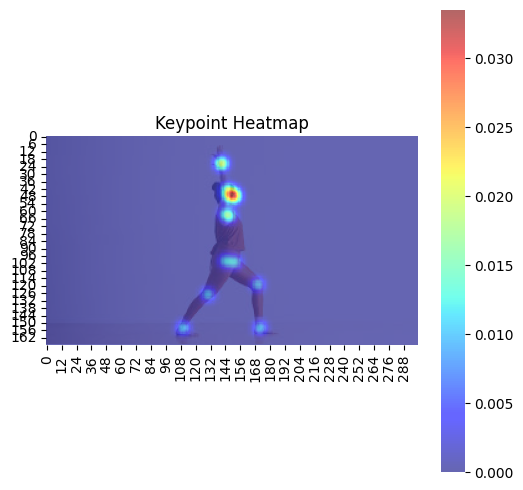

Processing Time: 3.25 seconds


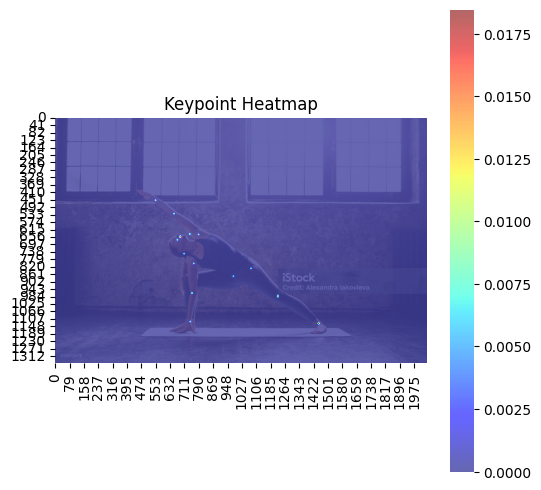

Processing Time: 3.28 seconds


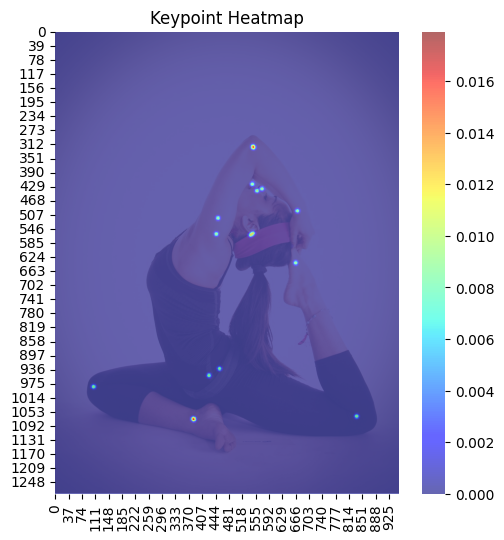

Processing Time: 3.51 seconds


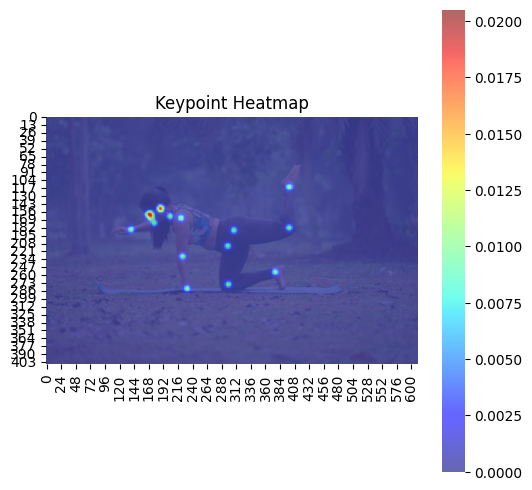

Processing Time: 3.52 seconds


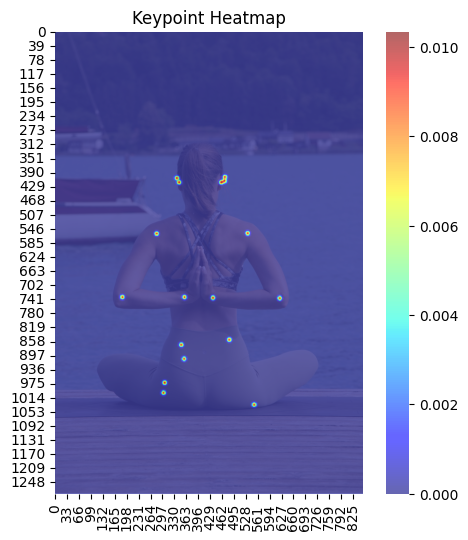

Processing Time: 3.48 seconds


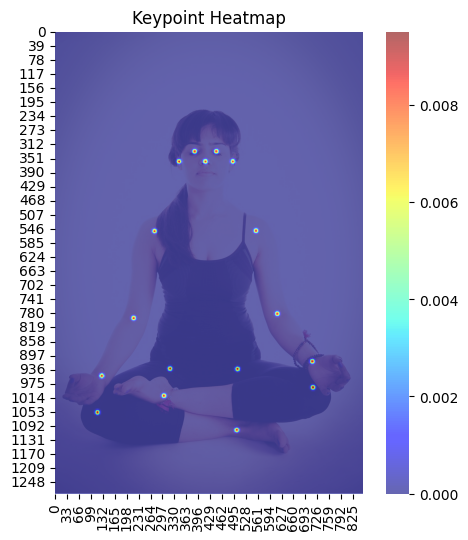

Processing Time: 3.36 seconds


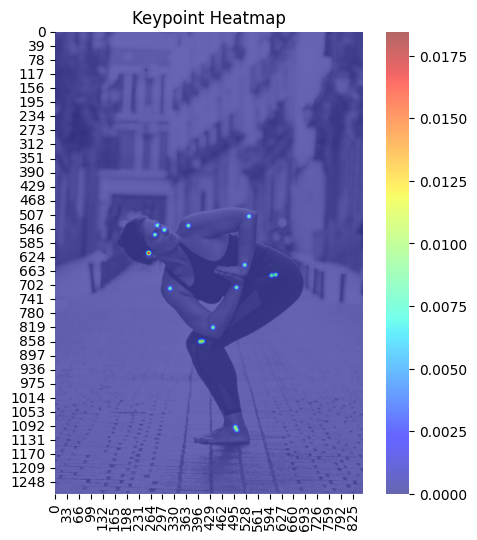

Processing Time: 3.24 seconds


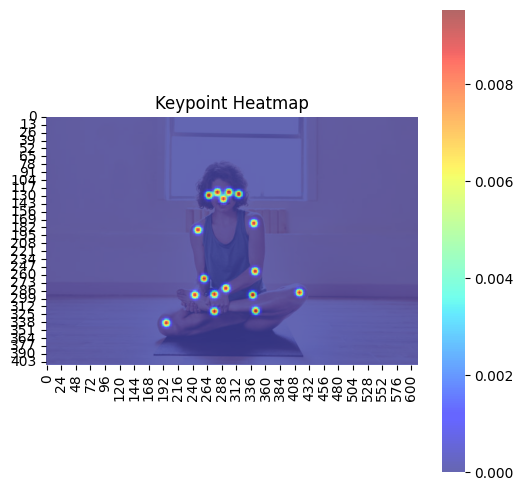

Processing Time: 3.18 seconds


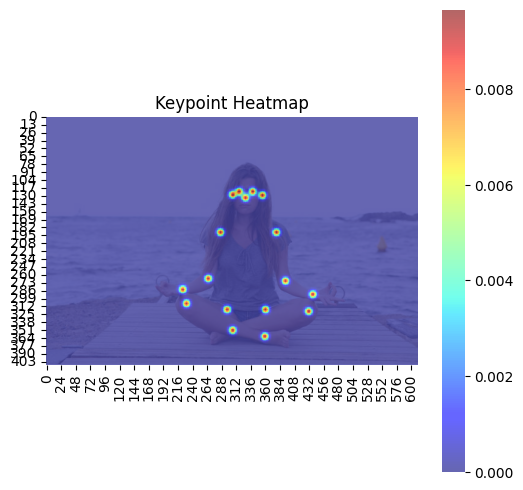

Processing Time: 3.60 seconds


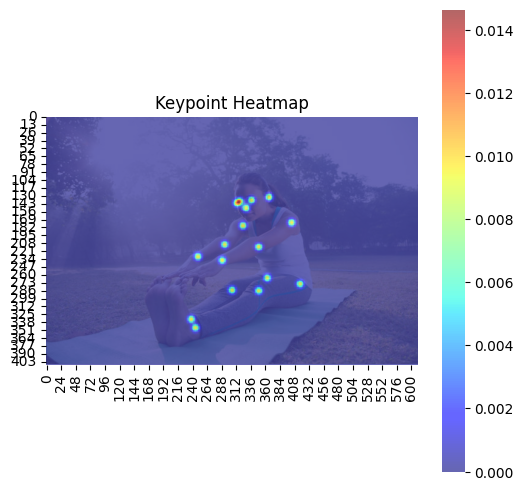

Processing Time: 3.31 seconds


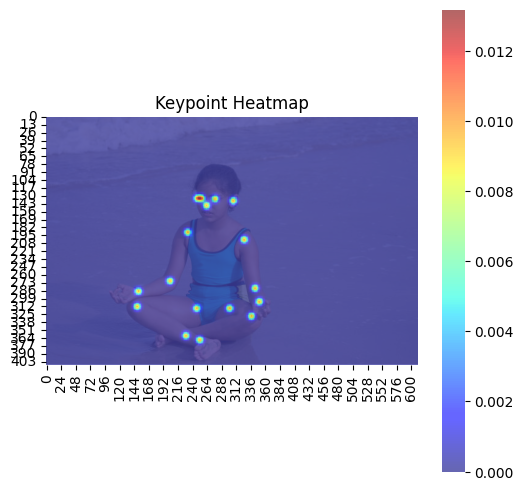

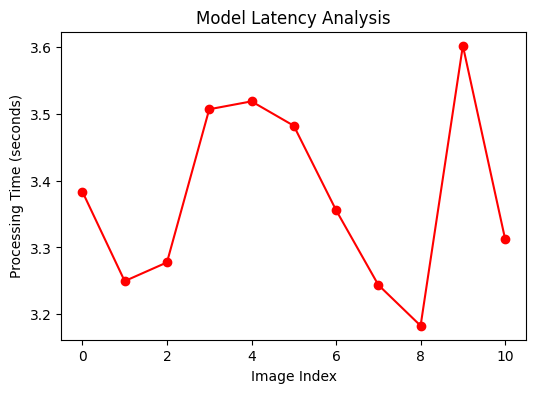

Results saved to pose_analysis_results.csv


In [5]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import time
import pandas as pd
from torchvision import transforms
from torchvision.models.detection import keypointrcnn_resnet50_fpn
from sklearn.metrics import confusion_matrix

# Load the pre-trained Keypoint R-CNN model
model = keypointrcnn_resnet50_fpn(pretrained=True)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define function for heatmap visualization
def generate_heatmap(image, keypoints):
    heatmap = np.zeros(image.shape[:2], dtype=np.float32)
    for x, y, conf in keypoints:
        if conf > 0.5:
            heatmap[int(y), int(x)] = 1.0
    heatmap = cv2.GaussianBlur(heatmap, (25, 25), 0)
    plt.figure(figsize=(6, 6))
    plt.imshow(image, alpha=0.5)
    sns.heatmap(heatmap, cmap='jet', alpha=0.6)
    plt.title("Keypoint Heatmap")
    plt.show()

# Load and process image
def load_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    transform = transforms.Compose([transforms.ToTensor()])
    return img, transform(img).to(device)

# Folder containing images (Update Path)
image_folder = r"C:\Users\ASUS\Desktop\projeccct\HumanPoseEstimation\images"
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Track pose accuracy over time
pose_accuracies = []
time_taken = []

# Process each image
for image_path in image_files:
    start_time = time.time()
    img, img_tensor = load_image(image_path)

    with torch.no_grad():
        output = model([img_tensor])

    keypoints = output[0]['keypoints'][0].cpu().numpy()
    end_time = time.time()

    # Measure latency
    latency = end_time - start_time
    time_taken.append(latency)
    print(f"Processing Time: {latency:.2f} seconds")

    # Generate Heatmap for keypoint accuracy
    generate_heatmap(img, keypoints)

# Plot latency over images
plt.figure(figsize=(6, 4))
plt.plot(range(len(time_taken)), time_taken, marker='o', linestyle='-', color='r')
plt.xlabel("Image Index")
plt.ylabel("Processing Time (seconds)")
plt.title("Model Latency Analysis")
plt.show()

# Save data for research paper
df = pd.DataFrame({"Image Index": range(len(time_taken)), "Processing Time (s)": time_taken})
df.to_csv("pose_analysis_results.csv", index=False)
print("Results saved to pose_analysis_results.csv")
